# Tugas Akhir - Python Data Science - Machine Learning & Public Opinion Analysis (Batch 39)

## Sentiment Analysis of TV Digital
1. Business Understanding


    <img src="img/news.png" alt="" >

Per tanggal 2 November 2022, Pemerintahan Indonesia melalui kominfo resmi memberhentikan layanan TV Analog dan beralih ke layanan TV Digital. Tentunya ini akan menimbulkan pro dan kontra dari masyarakat.

Project ini bertujuan untuk melihat sentimen masyarakat terhadap peralihan layanan ini. Dataset yang digunakan adalah hasil *scraping* dari Twitter API dan situs detik.com





2. Data Understanding
- Data Collection

    Dataset diambil dari Twitter API dan situs berita detik.com

In [479]:
# library python yang digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import requests
import re, string
import tweepy
from bs4 import BeautifulSoup
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
import nltk
from nltk.probability import FreqDist
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [480]:
# untuk membaca kode kredensial dari file mytoken.json
with open("mytoken.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [481]:
# fungsi untuk melalakukan data collecting dari Twitter API menggunakan library tweepy
def tweetCollecting():
    api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

    query = "tv digital -is:retweet lang:id" # Merupakan kata kunci yang dicari tanpa retweet dan berbahasa indonesia 
    start = datetime.datetime(2022,11,7) # Tanggal awal
    end = datetime.datetime(2022,11,11) # Tanggal akhir
    
    tweets = tweepy.Paginator(api.search_recent_tweets,
                            query=query, 
                            tweet_fields=['context_annotations', 'created_at'],
                            start_time=start,
                            end_time=end, 
                            max_results=100).flatten(limit=1500)
    data =[]
    for tweet in tweets:
        cell= {}
        cell["tanggal"]=tweet.created_at
        cell["tweets"]= tweet.text.strip() 
        data.append(cell)
    
    output = pd.DataFrame(data).to_csv("data/tweet_tvdigital.csv", index=False)
    return output


In [482]:
tweets = tweetCollecting()

In [483]:
# Fungsi untuk melakukan web scraping detik.com dengan kata kunci "Tv Digital"
def newsCollecing():
    url ='https://www.detik.com/search/searchall?query=tv%20digital&sortby=time&page='
    data= []
    for i in range(1,11):
        page = requests.get(url + str(i) + '/')
        soup = BeautifulSoup(page.content, 'html.parser')
        items = soup.findAll("div", {"class":"list-berita"})
        for item in items:
            titles = item.findAll('h2')
            for title in titles:
                data.append(title.get_text())
    output = pd.DataFrame(data, columns=['judul']).to_csv("data/news_tvdigital.csv", index=False)
    return output

In [484]:
news = newsCollecing()

- Data Analysis

In [495]:
# Membaca dataset
df_tweets = pd.read_csv('data/tweet_tvdigital.csv')
df_news = pd.read_csv('data/news_tvdigital.csv')

In [496]:
# Melihat 5 data awal dari dataset
df_tweets.head()

,tanggal,tweets
0,2022-11-10 23:57:54+00:00,"digital digital apaan, chanel yg gk ketangkep ..."
1,2022-11-10 23:49:56+00:00,@AREAJULID kamu komenin tv digital tpi isi pic...
2,2022-11-10 23:49:18+00:00,@AREAJULID hadehh rada2 emng udh di ksh juga m...
3,2022-11-10 23:48:18+00:00,"@AREAJULID pertama , cel dulu daerah tempat ti..."
4,2022-11-10 23:48:02+00:00,@siarandigital Wes angel² sinyal tv digital sa...


In [497]:
# Melihat 5 data terkhir dari dataset
df_news.tail()

,judul
85,Cara Menonton Siaran TV Digital
86,Lokasi Pembagian Set Top Box Gratis TV Digital...
87,Pemerintah Cabut Izin TV MNC Group dan VIVA Gr...
88,Belum Dapat Set Top Box Gratis? Chat Nomor Wha...
89,"TV Analog Mati, Pembagian Set Top Box Gratis d..."


In [499]:
# Melihat ukuran dari dataset
df_tweets.shape, df_news.shape

((1500, 2), (90, 1))

In [500]:
# Melihat type data dari dataset
display(df_tweets.dtypes)
print("-"*15)
df_news.dtypes

tanggal    object
tweets     object
dtype: object

---------------


judul    object
dtype: object

- Data Preprocessing

In [501]:
# Fugsi untuk mengambil tanggal dari data
def editDate(data):
    data = data.split(' ')[0]
    return data

In [502]:
# Fungsi untuk manipulasi text
def caseFolding(data):
    # Membuat text menjadi huruf kecil semua
    data = data.lower()
    # Menghapus username, hashtag, url, dan simbol
    data = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    # Menhapus angka
    data = re.sub(r"\d+", "", data)
    data = re.sub('(?i)username','',data)
    # Menghapus tanda baca
    data = data.translate(str.maketrans("","",string.punctuation))
    #menghapus whitespace
    data = data.strip()
    return data

In [503]:
# Fungsi untuk menghapus stopwords
def stopwordCleaner(data):
    list_negasi = ['tidak','lawan','anti', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'tak']
    # bertujuan untuk mengecualian kata yang terdapat pada list_negari dari stopwords indonesia
    sw_indonesia = set(stopwords.words("indonesian")) - set(list_negasi)
    data = word_tokenize(data)
    data  = [word for word in data  if word not in sw_indonesia]
    data = ' '.join(data)
    return data

In [504]:
df_tweets['tanggal'] = df_tweets['tanggal'].apply(lambda x:editDate(x))
df_tweets['tweet_clean'] = df_tweets['tweets'].apply(lambda x:caseFolding(x))
df_tweets['tweet_clean'] = df_tweets['tweet_clean'].apply(lambda x:stopwordCleaner(x))
df_tweets.head()

,tanggal,tweets,tweet_clean
0,2022-11-10,"digital digital apaan, chanel yg gk ketangkep ...",digital digital chanel yg gk ketangkep sinyal ...
1,2022-11-10,@AREAJULID kamu komenin tv digital tpi isi pic...,komenin tv digital tpi isi pict permasalahin s...
2,2022-11-10,@AREAJULID hadehh rada2 emng udh di ksh juga m...,hadehh rada emng udh ksh msh nyalahin bpk gw n...
3,2022-11-10,"@AREAJULID pertama , cel dulu daerah tempat ti...",cel daerah tinggal siaran digital kekuatan sin...
4,2022-11-10,@siarandigital Wes angel² sinyal tv digital sa...,wes angel sinyal tv digital merata nya diberla...


3. Data Processing
- Text Data Analys

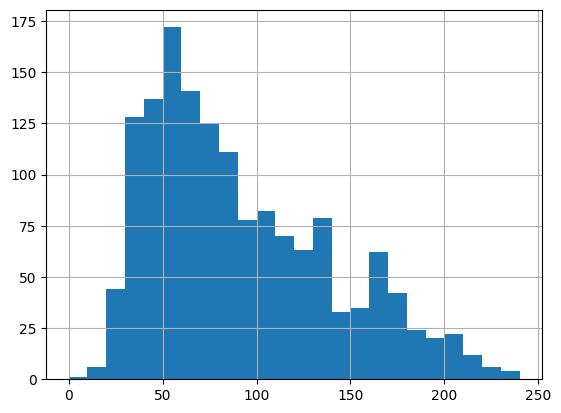

In [505]:
# Dsitribusi frekuensi karakter per tweets
bin_range = np.arange(0, 250, 10)
df_tweets['tweet_clean'].str.len().hist(bins=bin_range)
plt.show()

Distribusi jumlah karakter terbanyak berada pada 50 - 70 karakter per tweet.

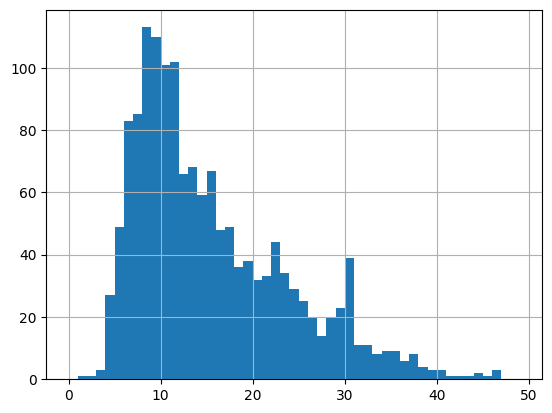

In [506]:
# Distribusi Jumlah kata per teets
bin_range = np.arange(0, 50)
df_tweets['tweet_clean'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

Distribusi jumlah kata terbanyak pada 7 - 10 kata

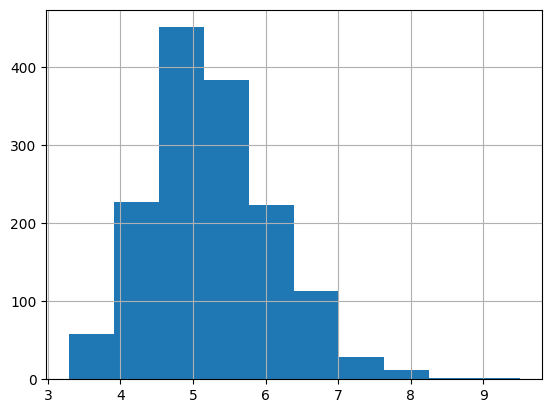

In [508]:
# Distribusi Frekuensi Panjang Kata Rata-Rata
df_tweets['tweet_clean'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

Distribusi jumlah karakter rata - rata adalah 5 per kata

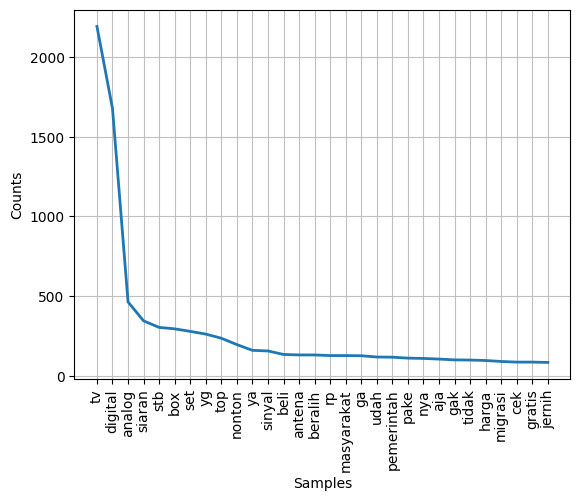

In [509]:
# Distribusi Kata
token_tweet = df_tweets['tweet_clean'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in token_tweet for word in tweet]
fqdist = FreqDist(tweets)
most_common_word = fqdist.most_common(30)
fqdist.plot(30,cumulative=False)

plt.show()

Dan untuk distribusi kata, didominasi oleh kata TV dan diikuti kata digital dan Analog.

In [510]:
# Fungsi untuk menghapus kata-kata slang yang paling banyak muncul
def slangCleaner(data):
    slang = ['yg', 'ya', 'nya', 'rp', 'aja', 'udah', 'kalo', 't']
    data = word_tokenize(data)
    data  = [word for word in data if word not in slang]
    data = ' '.join(data)
    return data
    

In [511]:
df_tweets['tweet_clean'] = df_tweets['tweet_clean'].apply(lambda x:slangCleaner(x))

In [512]:
#distribusi N-gram
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print (result)

(tv, digital)        1211
(tv, analog)          344
(set, top)            233
(top, box)            231
(siaran, tv)          206
(box, tv)             110
(beralih, tv)         100
(analog, tv)           98
(digital, tv)          97
(nonton, tv)           87
(dvb, t)               79
(analog, digital)      72
(migrasi, tv)          60
(siaran, digital)      56
(mie, sehat)           55
(stb, tv)              43
(box, gratis)          40
(peralihan, tv)        38
(harga, rp)            36
(pake, tv)             35
dtype: int64


- Sentiment Analysis - Manual Polarization

In [513]:
# membaca file referensi kata positif dan negatif 
with open(".data/kata_positif.txt","r") as positif_file :
  positive_words = list(set(positif_file.readlines()))
with open(".data/kata_negatif.txt","r") as negative_file :
  negative_words = list(set(negative_file.readlines()))

In [514]:
hasil = []

tweets = df_tweets['tweet_clean']
for tweet in tweets:

  tweet_clean = tweet.strip().split()
    
  good_count = 0 #nilai positif
  bad_count = 0 #nilai negatif

  for good_word in positive_words:
    count = tweet_clean.count(good_word.strip().lower())
    if count > 0:
      good_count += count

  for bad_word in negative_words:
    count = tweet_clean.count(bad_word.strip().lower())
    if count > 0:
      bad_count += count
  hasil.append(good_count - bad_count)

sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df_tweets["sentiment_MP"] = sentiments

In [515]:
print (f'''
Mean: {np.mean(hasil)}
Median: {np.median(hasil)}
quartil awal: {np.quantile(hasil,0.25)}
quartil akhir: {np.quantile(hasil,0.75)}
Standar deviasi: {np.std(hasil)}     
''')


Mean: 0.14466666666666667
Median: 0.0
quartil awal: 0.0
quartil akhir: 1.0
Standar deviasi: 1.0781488250185542     



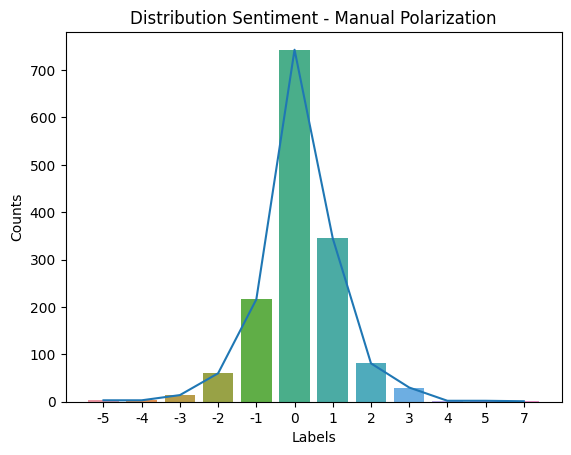

In [516]:
labels, counts = np.unique(hasil, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())

sns.barplot(x = list(labels), 
            y = list(counts))

sns.lineplot(x = ax.get_xticks(), 
            y = list(counts))

plt.title(f'Distribution Sentiment - Manual Polarization')
plt.xlabel('Labels')
plt.ylabel('Counts')

plt.show()

<AxesSubplot: xlabel='sentiment_MP', ylabel='count'>

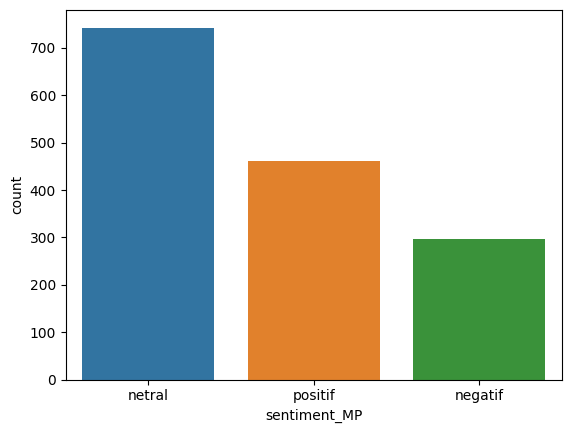

In [517]:
sns.countplot(data= df_tweets, x='sentiment_MP', order=df_tweets['sentiment_MP'].value_counts().index )

Dari distribusi sentiment mengunakan metode manual polarization, sentiment masyarakat terhadap TV Digital didominasi dengan sentiment netral

- Sentiment Analysis - Naive Bayes

In [518]:
#data training
df_train = pd.read_csv('data/dataset_komentar_instagram_cyberbullying.csv')

In [519]:
df_train.rename(columns={"Instagram Comment Text":"Text"}, inplace=True)
df_train.drop(columns=["Id"],inplace=True,)
df_train.replace({"Sentiment":{"negative":0, "positive":1}}, inplace=True)
df_train.head()

,Sentiment,Text
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [520]:
df_train['tweet_clean'] = df_train["Text"].apply(lambda x:caseFolding(x))
df_train['tweet_clean'] = df_train['tweet_clean'].apply(lambda x:stopwordCleaner(x))
df_train.head()


,Sentiment,Text,tweet_clean
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak hubungan nya keguguran dgn pake hija...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibelain balikan hadew...
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh labil bgt s...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kesel att nya gausah anaknya kasian pe...
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lg sakit jiwa knp yg jd per...


In [521]:
# Mengubah data text menjadi matriks dengan metode TF-IDF pada library sklearn dan gaussian Naive Bayes
vectorizer = TfidfVectorizer (max_features=2500)
model_g = GaussianNB()

In [522]:
# Mengubah df_train['tweet_clean'] menjadi TFIDF Vectorizer
v_data = vectorizer.fit_transform(df_train['tweet_clean']).toarray()

In [523]:
# Melakkan training model
X_train, X_test, y_train, y_test = train_test_split(v_data, df_train['Sentiment'], test_size=0.2, random_state=18)

model_g.fit(X_train,y_train)

GaussianNB()

In [524]:
# Melakukan prediksi dan penghitungan confussion matrix, classification report, dan accuracy score
y_preds = model_g.predict(X_test)

print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

[[36  6]
 [ 5 33]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        42
           1       0.85      0.87      0.86        38

    accuracy                           0.86        80
   macro avg       0.86      0.86      0.86        80
weighted avg       0.86      0.86      0.86        80

nilai akurasinya adalah  0.8625


Nilai Akurasi, Precision, Recall, F1-Score diatas 80 menunjukkan model yang cukup baik untuk kasus ini

In [525]:
# Melakukan klasifikasi statement pada dataset df_tweets
v_data = vectorizer.transform(df_tweets["tweet_clean"]).toarray()

y_classification = model_g.predict(v_data)

df_tweets["sentiment_NB"] = list(y_classification)

In [526]:
df_tweets.to_csv('data/tweet_sentiment.csv', index=False)
df_tweets.head(10)

,tanggal,tweets,tweet_clean,sentiment_MP,sentiment_NB
0,2022-11-10,"digital digital apaan, chanel yg gk ketangkep ...",digital digital chanel gk ketangkep sinyal ila...,positif,1
1,2022-11-10,@AREAJULID kamu komenin tv digital tpi isi pic...,komenin tv digital tpi isi pict permasalahin s...,netral,1
2,2022-11-10,@AREAJULID hadehh rada2 emng udh di ksh juga m...,hadehh rada emng udh ksh msh nyalahin bpk gw n...,netral,1
3,2022-11-10,"@AREAJULID pertama , cel dulu daerah tempat ti...",cel daerah tinggal siaran digital kekuatan sin...,netral,1
4,2022-11-10,@siarandigital Wes angel² sinyal tv digital sa...,wes angel sinyal tv digital merata diberlakukan,netral,1
5,2022-11-10,Cek Weyon tv digital 21 inch HD tv led 24 inch...,cek weyon tv digital inch hd tv led inch telev...,netral,1
6,2022-11-10,"Apakah TV Hisense Sudah Digital, Cek di Sini h...",tv hisense digital cek,netral,1
7,2022-11-10,Untuk paket Vidio World Cup ini anda dapat men...,paket vidio world cup menyaksikan pertandingan...,netral,1
8,2022-11-10,@_fanani7 @R_Perkasa @kareesnikoray @PramSada ...,sempet ketar ketir krn platform ott nyiarin fu...,netral,1
9,2022-11-10,@irsyahan_ @R_Perkasa @kareesnikoray @PramSada...,mantap skrng tv digitalnya emtek cling piala d...,positif,1


<AxesSubplot: xlabel='sentiment_NB', ylabel='count'>

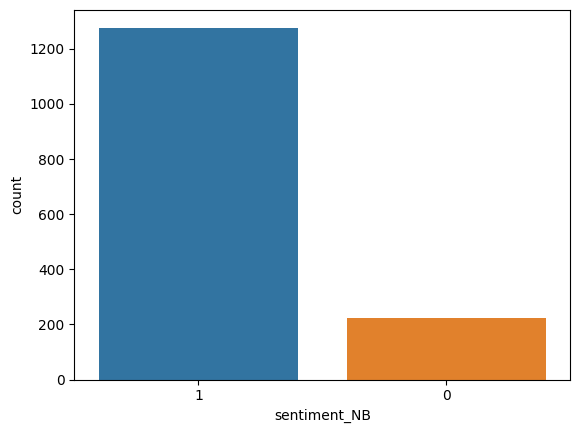

In [527]:
sns.countplot(data= df_tweets, x='sentiment_NB', order=df_tweets['sentiment_NB'].value_counts().index)

Dari distribusi sentiment mengunakan metode Naive Bayes, sentiment masyarakat terhadap TV Digital didominasi dengan sentiment positif

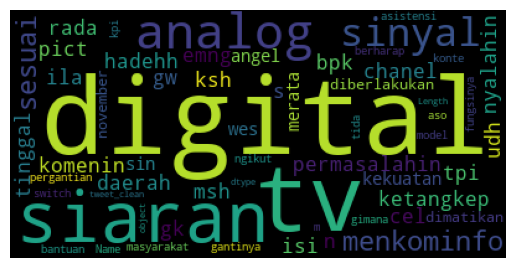

In [528]:
positif = df_tweets[df_tweets['sentiment_NB'] == 1]
plt.imshow(WordCloud().generate(str(positif['tweet_clean'])))
plt.axis('off')
plt.show()

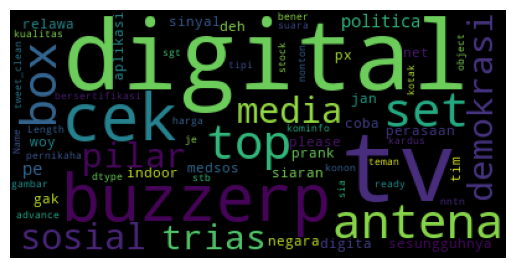

In [529]:
negatif = df_tweets[df_tweets['sentiment_NB'] == 0]
plt.imshow(WordCloud().generate(str(negatif['tweet_clean'])))
plt.axis('off')
plt.show()

4. Analisis

Dari teks analisis yang telah dilakukan dapat diketahui bahwa distribusi jumlah karakter terbanyak berada pada 50 - 70 karakter per tweet. Sedangkan distribusi jumlah kata terbanyak pada 7 - 10 kata dengan jumlah karakter rata - rata adalah 5 per kata. Dan untuk distribusi kata, didominasi oleh kata TV dan diikuti kata digital dan analog.

Berdasarkan analisis sentiment mengunakan  metode manual polarization dapat diketahui bahwa sentimen masyarakat terhadap peralihan ke TV digital didominasi sentiment netral

Sedangkan berdasarkan analisis sentiment mengunakan Naive Bayes dapat diketahui bahwa sentimen masyarakat terhadap peralihan ke TV digital didominasi sentiment positif



5. Kesimpulan

Sentiment masyarakat terhadap peralihan layanan TV Analog ke layanan TV Digital berdasarkan analisis sentimen menggunakan metode naive bayes adalah positif, dengan artian masyarakat mendukung program ini.

Hasil ini bukan tanpa cacat, masih banyak catatan yang harus dilakukan agar data yang dianalisis bisa lebih valid. Sample diperbanyak, pembersihan ditingkatkan, dan algoritma diperbaiki.

Referensi

- https://github.com/riochr17/Analisis-Sentimen-ID 
- https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia